# Solving the Navier-Stokes equation with tensor-product space-time FEM in FEniCS and equal order dG(r)-discretization for velocity and pressure

In [27]:
# FEniCS for spatial FEM
try:
    import dolfin
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/fenics-install.sh" -O "/tmp/fenics-install.sh" && bash "/tmp/fenics-install.sh"
    import dolfin

## Create temporal basis in SymPy

In [28]:
import numpy as np
import matplotlib.pyplot as plt
from sympy import Mul, Id, symbols, init_printing, expand, compose, diff, lambdify, Piecewise
from IPython.display import Math, display
from fenics import Mesh, VectorElement, Function, TrialFunction, TestFunction, TestFunctions, FunctionSpace, dx, inner, grad, FiniteElement, MixedElement, Constant, assemble, Expression, interpolate, solve, DirichletBC, plot, errornorm, set_log_active, derivative, parameters, split, dot, div, CompiledSubDomain, MeshFunction, sqrt, Measure, FacetNormal, Identity
from ufl import replace
import time
import pandas as pd

set_log_active(False) # turn off FEniCS logging
parameters["reorder_dofs_serial"] = False

t = symbols("t")
init_printing()

TIME_DG_QUADRATURE = "Gauss-Lobatto"
PROBLEM = "2D-3" #"2D-2"

# HELPER FUNCTIONS
# compute temporal basis functions from the roots
def compute_basis_functions(roots):
    basis = []
    for i in range(len(roots)):
        f = 1 + 0*Id(t)
        for j in range(len(roots)):
            if i != j:
                f = Mul(f,(t - roots[j]) / (roots[i] - roots[j]))
        #basis.append(f)
        basis.append(expand(f))
    return basis

# transform roots from [-1, 1] to [0, 1]
def transform_roots(roots):
    new_roots = []
    for root in roots:
        new_roots.append((root + 1) / 2)
    return new_roots

# dictionary of temporal bases depending on the polynomial degree
# FE basis on reference element (0,1)
φ = {}
roots = {}

roots[0] = [1.]
φ[0] = [1 + 0*Id(t)]
roots[1] = [0., 1.]
φ[1] = [1-t, t]
roots[2] = transform_roots([-1, 0, 1])
φ[2] = compute_basis_functions(roots[2])

class TimeFE:
    def __init__(self, r=1, a=0., b=1., n_time=1, n_q_points=3):
        self.r = r # polynomial degree in time
        self.n_time = n_time # number of temporal elements
        self.n_dofs = (self.r+1) * self.n_time # total number of temporal dofs on slab
        self.dof_locations = []
        self.a = a # start time of slab
        self.b = b # end time of slab
        self.k = (self.b - self.a) / self.n_time
        self.epsilon = self.k * 1e-10

        self.generate_mesh()
        self.get_full_basis()
        self.lambdify_basis()
        self.compute_quadrature(n_q_points)

    def generate_mesh(self):
        # create an uniform temporal mesh with mesh size self.k
        self.mesh = [(self.a, self.a+self.k)]
        while len(self.mesh) < self.n_time:
            self.mesh.append((self.mesh[-1][1], self.mesh[-1][1]+self.k))

    # transform basis functions from [0,1] to [a,b]
    def transform_function(self, f, a, b):
        return compose(f, (t-a)/(b-a)) # = f((t-a)/(b-a))
    
    def transform_derivative(self, a, b):
        return 1 / (b-a)

    # get full FE basis and its derivative on temporal mesh
    def get_full_basis(self):
        self._basis = []
        self._basis_derivative = []
        self.local_dofs = {}
        i = 0
        for (a,b) in self.mesh:
            self.local_dofs[(a,b)] = []
            for f, t_q in zip(φ[self.r], roots[self.r]):
                self._basis.append(self.transform_function(f, a, b))
                self._basis_derivative.append(diff(self._basis[-1],t))
                #print(diff(self._basis[-1],t))
                #print(self.transform_function(diff(f,t), a, b) * self.transform_derivative(a, b))
                self.local_dofs[(a,b)].append(i)
                self.dof_locations.append(t_q*(b-a)+a)
                i += 1

    # convert SymPy functions to Python functions and ensure that they are 0 outside the element that they are defined on
    def lambdify_basis(self):
        self.phi = []
        self.dt_phi = []

        for (a,b) in self.mesh:
            for i in self.local_dofs[(a,b)]:
                self.phi.append(
                    lambdify(
                        t,
                        Piecewise(
                            (0, t < a),
                            (0, t > b),
                            (self._basis[i], True)
                        )
                    )
                )

                self.dt_phi.append(
                    lambdify(
                        t,
                        Piecewise(
                            (0, t < a),
                            (0, t > b),
                            (self._basis_derivative[i], True)
                        )
                    )
                )

    def compute_quadrature(self, n_q_points):
        # Gauss-Legendre quadrature points and weights on [-1,1]
        quad_points, quad_weights = np.polynomial.legendre.leggauss(n_q_points)

        # transform quadrature points and weights from [-1,1] to [a,b] for each temporal element [a,b]
        self.quadrature = {}
        for (a, b) in self.mesh:
            t_q = 0.5 * (b-a) * quad_points + 0.5 * (a+b)
            w_q = 0.5 * (b-a) * quad_weights
            self.quadrature[(a,b)] = [(t_q[i], w_q[i]) for i in range(t_q.shape[0])]
            
        # Gauss-Legendre quadrature points and weights on [-1,1]
        quad_points, quad_weights = np.polynomial.legendre.leggauss(n_q_points+2)

        # transform quadrature points and weights from [-1,1] to [a,b] for each temporal element [a,b]
        self.quadrature_fine = {}
        for (a, b) in self.mesh:
            t_q = 0.5 * (b-a) * quad_points + 0.5 * (a+b)
            w_q = 0.5 * (b-a) * quad_weights
            self.quadrature_fine[(a,b)] = [(t_q[i], w_q[i]) for i in range(t_q.shape[0])]

    def plot_basis(self, basis_type="function", title=None):
        assert basis_type in ["function", "derivative"], f"basis_type='{basis_type}' has not been implemented."

        _t = np.linspace(self.a, self.b, 100)
        for i in range(len(self.phi)):
            if basis_type == "function":
                plt.plot(_t, [self.phi[i](time_point) for time_point in _t], label=rf"$\varphi_{{{i}}}$")
            elif basis_type == "derivative":
                plt.plot(_t, [self.dt_phi[i](time_point) for time_point in _t], label=rf"$\partial_t \varphi_{{{i}}}$")

        plt.xlabel("t")
        plt.ylabel("f(t)")
        plt.legend()
        if title is not None:
            plt.title(title)
        plt.show()
        
    def get_solution_at_time(self, time_point, U):
        tmp = np.zeros_like(U[0])
        for i in range(self.n_dofs):
            tmp += Time.phi[i](time_point) * U[i]
        return tmp

## Assemble space-time integrals using numerical quadrature in time and FEniCS forms in space

CONFIG: problem = 2D-3, s = (2/1), r = 1 (Gauss-Lobatto), slab_size = 0.03125, n_x = 1


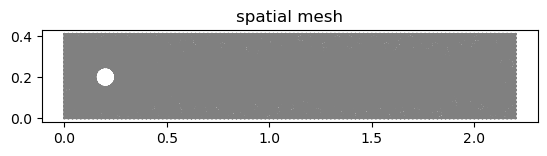

Number of spatial DoFs: 40007 (24574 + 3146 + 12287)
Solving on slab_0 = Ω x (0.0, 0.03125) ...
Spaces = [v,v,p,p,p,p,]
[0, 1]
[0, 1]
[0, 1]
[0, 1]
[0, 1]
[0, 1]
[0, 1]
[0, 1]
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
t = 0.03125:


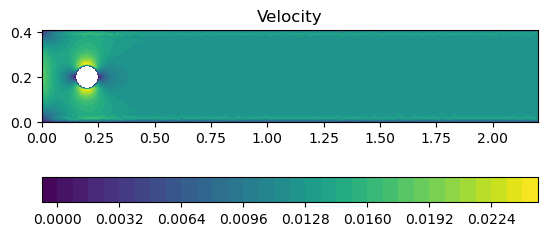

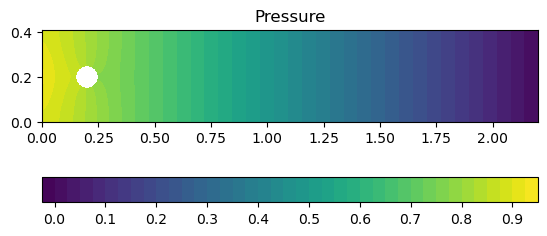

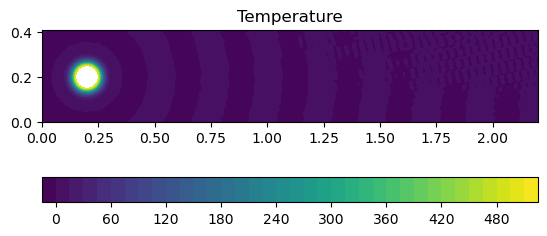

Done.

Solving on slab_1 = Ω x (0.03125, 0.0625) ...
Spaces = [v,v,p,p,p,p,]
[0, 1]
[0, 1]
[0, 1]
[0, 1]
[0, 1]
[0, 1]
[0, 1]
[0, 1]
Done.

Solving on slab_2 = Ω x (0.0625, 0.09375) ...
Spaces = [v,v,p,p,p,p,]
[0, 1]
[0, 1]
[0, 1]
[0, 1]
[0, 1]
[0, 1]
[0, 1]
[0, 1]
Done.

Solving on slab_3 = Ω x (0.09375, 0.125) ...
Spaces = [v,v,p,p,p,p,]
[0, 1]
[0, 1]
[0, 1]
[0, 1]
[0, 1]
[0, 1]
[0, 1]
[0, 1]
Done.

Solving on slab_4 = Ω x (0.125, 0.15625) ...
Spaces = [v,v,p,p,p,p,]
[0, 1]
[0, 1]
[0, 1]
[0, 1]
[0, 1]
[0, 1]
[0, 1]
[0, 1]
Done.

Solving on slab_5 = Ω x (0.15625, 0.1875) ...
Spaces = [v,v,p,p,p,p,]
[0, 1]
[0, 1]
[0, 1]
[0, 1]
[0, 1]
[0, 1]
[0, 1]
[0, 1]
Done.

Solving on slab_6 = Ω x (0.1875, 0.21875) ...
Spaces = [v,v,p,p,p,p,]
[0, 1]
[0, 1]
[0, 1]
[0, 1]
[0, 1]
[0, 1]
[0, 1]
[0, 1]
Done.

Solving on slab_7 = Ω x (0.21875, 0.25) ...
Spaces = [v,v,p,p,p,p,]
[0, 1]
[0, 1]
[0, 1]
[0, 1]
[0, 1]
[0, 1]
[0, 1]
[0, 1]
Done.

Solving on slab_8 = Ω x (0.25, 0.28125) ...
Spaces = [v,v,p,p,p,p,

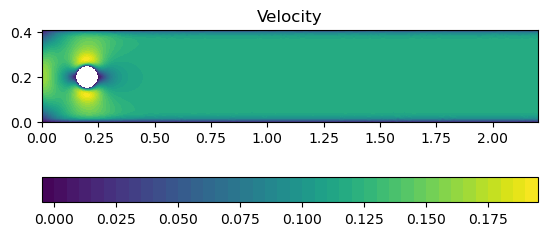

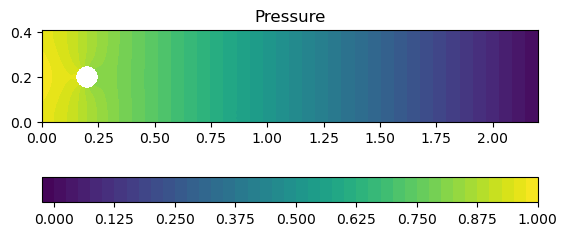

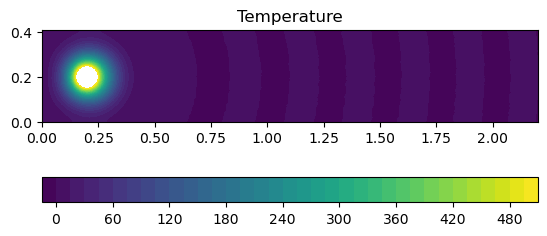

Done.

Solving on slab_9 = Ω x (0.28125, 0.3125) ...
Spaces = [v,v,p,p,p,p,]
[0, 1]
[0, 1]
[0, 1]
[0, 1]
[0, 1]
[0, 1]
[0, 1]
[0, 1]
Done.

Solving on slab_10 = Ω x (0.3125, 0.34375) ...
Spaces = [v,v,p,p,p,p,]
[0, 1]
[0, 1]
[0, 1]
[0, 1]
[0, 1]
[0, 1]
[0, 1]
[0, 1]
Done.

Solving on slab_11 = Ω x (0.34375, 0.375) ...
Spaces = [v,v,p,p,p,p,]
[0, 1]
[0, 1]
[0, 1]
[0, 1]
[0, 1]
[0, 1]
[0, 1]
[0, 1]


In [29]:
##############################################
# Start a time marching / time slabbing loop #
##############################################
start_time = 0.
end_time = 8.

s_v = 2
s_p = 1
s_e = 2
r = 1
slab_size = 0.03125
n_x = 1
nu0 = 0.001
Ea=1
R=1
k_heat=0.01



# start simulation
cpu_start_time = time.time()
print(f"CONFIG: problem = {PROBLEM}, s = ({s_v}/{s_p}), r = {r} ({TIME_DG_QUADRATURE}), slab_size = {slab_size}, n_x = {n_x}")

slabs = [(start_time, start_time+slab_size)]
while slabs[-1][1] < end_time - 1e-8:
    slabs.append((slabs[-1][1], slabs[-1][1]+slab_size))

# get spatial function space
#space_mesh = Mesh("schaefer_turek_2D_fine.xml") # decent results, fine mesh with ~50 K DoFs for Taylor-Hood
space_mesh = Mesh("schaefer_turek_2D_pygmsh.xml") # mesh with ~28 K DoFs for Taylor-Hood
# space_mesh = Mesh("schaefer_turek_2D.xml") # too coarse for accurate lift
plot(space_mesh, title="spatial mesh")
plt.show()
element = {
    "v": VectorElement("Lagrange", space_mesh.ufl_cell(), s_v),
    "p": FiniteElement("Lagrange", space_mesh.ufl_cell(), s_p),
    "e": FiniteElement("Lagrange", space_mesh.ufl_cell(), s_e),
}
Vh = FunctionSpace(space_mesh, MixedElement(*element.values())) # spatial function space for a single time point
print(f"Number of spatial DoFs: {Vh.dim()} ({Vh.sub(0).dim()} + {Vh.sub(1).dim()} + {Vh.sub(2).dim()})")
Uh = Function(Vh)
Phih = TestFunctions(Vh)

# boundaries
inflow = CompiledSubDomain("near(x[0], 0) && on_boundary")
outflow = CompiledSubDomain("near(x[0], 2.2) && on_boundary")
walls = CompiledSubDomain("near(x[1], 0) || near(x[1], 0.41) && on_boundary")
cylinder = CompiledSubDomain("x[0]>0.1 && x[0]<0.3 && x[1]>0.1 && x[1]<0.3 && on_boundary")

facet_marker = MeshFunction("size_t", space_mesh, 1)
facet_marker.set_all(0)
inflow.mark(facet_marker, 1)
outflow.mark(facet_marker, 2)
walls.mark(facet_marker, 3)
cylinder.mark(facet_marker, 4)

ds_cylinder = Measure("ds", subdomain_data=facet_marker, subdomain_id=4)

# initial condition on slab
U0 = Function(Vh)
v0, p0, e0 = split(U0)
U0 = interpolate(Constant((0.,0.,0.,1.)), Vh)

# split functions into velocity and pressure components
v, p, e = split(Uh)
phi_v, phi_p, phi_e = Phih

# preassemble spatial forms
#mass_form = dot(v, phi_v) * dx
#laplace_form = inner(grad(v), grad(phi_v)) * dx
#pressure_form = p * div(phi_v) * dx
#div_form = div(v) * phi_p * dx
#convection_form = dot(dot(grad(v), v), phi_v) * dx

# pre-assemble drag and lift
dU = TrialFunction(Vh) 
dv, dp, de = split(dU)
D = 0.1
v_bar = 2/3 * 4.0*1.5*0.205*(0.41 - 0.205) / pow(0.41, 2)
#n = FacetNormal(space_mesh)
#drag_vector = assemble(
#    2/(v_bar**2*D)*
#    (
#    - dot(dp * Identity(len(dv)) , -n)[0]
#    + nu * dot(grad(dv), -n)[0]
#    ) * ds_cylinder
#).get_local()
#
#lift_vector = assemble(
#    2/(v_bar**2*D)*
#    (
#    - dot(dp * Identity(len(dv)) , -n)[1]
#    + nu * dot(grad(dv), -n)[1]
#    ) * ds_cylinder
#).get_local()
#
#drag_values = []
#lift_values = []
#times_draglift = []
total_n_dofs = 0
total_time_n_dofs = 0

#####################
# Time slabbing loop:
for k, slab in enumerate(slabs):
    print(f"Solving on slab_{k} = Ω x ({round(slab[0],5)}, {round(slab[1],5)}) ...")

    #########################################
    # Create temporal finite element object #
    #########################################
    Time = TimeFE(r=r, a=slab[0], b=slab[1], n_time=1, n_q_points=r+1)
    
    V = FunctionSpace(space_mesh, MixedElement(*[element["v"] for _ in range(Time.n_dofs)], *[element["p"] for _ in range(Time.n_dofs)], *[element["e"] for _ in range(Time.n_dofs)]))
    n_subspaces = V.num_sub_spaces()
    print("Spaces = [", end="")
    for i in range(n_subspaces):
        if V.sub(i).num_sub_spaces() == 2:
            print("v", end=",")
        else:
            print("p", end=",")
    print("]")
    
    U_kh = Function(V)
    Phi_kh = TestFunctions(V)

    # split U_kh and Phi_kh into velocity and pressure parts
    U = {"v": split(U_kh)[:Time.n_dofs], "p": split(U_kh)[Time.n_dofs: 2*Time.n_dofs], "e": split(U_kh)[2*Time.n_dofs:]}
    Phi = {"v": Phi_kh[:Time.n_dofs], "p": Phi_kh[Time.n_dofs: 2*Time.n_dofs], "e": Phi_kh[2*Time.n_dofs:]}
    
    # start with "empty" space-time variational form
    F = Constant(0.)*U["p"][0]*Phi["p"][0]*dx
    
    # ================= #
    #   (v,v) - Block   #
    # ================= #
    
    # volume integrals
    for time_element in Time.mesh:
        # assemble linear terms
        for i in Time.local_dofs[time_element]:
            for j in Time.local_dofs[time_element]:
                for (t_q, w_q) in Time.quadrature[time_element]:
                    print(Time.local_dofs[time_element])
                    # TODO: to reduce the number of terms in the sum, the sum over the temporal quadrature can be evaluated prior to adding to the form F
                    F += Constant(w_q * Time.dt_phi[j](t_q) * Time.phi[i](t_q)) \
                        * dot(U["v"][j], Phi["v"][i]) * dx
                    F += Constant(w_q * Time.phi[j](t_q) * Time.phi[i](t_q)) \
                        * nu0*pow(np.exp(0),Ea/(R*(U["e"][j] +273.5))) * inner(grad(U["v"][j]), grad(Phi["v"][i])) * dx
        # assemble nonlinearity
        for i in Time.local_dofs[time_element]:
            for j in Time.local_dofs[time_element]:
                for l in Time.local_dofs[time_element]:
                    # NOTE: For nonlinearities make sure that the temporal quadrature is fine enough
                    # E.g. for the nonlinearity u^2, we need to be able to integrate polynomials of degree 3r exactly in time
                    #      for this we need Gauss-Legendre quadrature of degree >= (3r+1)/2
                    for (t_q, w_q) in Time.quadrature_fine[time_element]:
                        F += Constant(w_q * Time.phi[j](t_q) * Time.phi[l](t_q) * Time.phi[i](t_q)) \
                            * dot(dot(grad(U["v"][j]), U["v"][l]), Phi["v"][i])* dx   
                        
                        
    # RHS integral
    for n, time_element in enumerate(Time.mesh):
        for i in Time.local_dofs[time_element]:
            # initial condition
            if n == 0:
                F -=  Constant(Time.phi[i](time_element[0]+Time.epsilon)) * inner(v0, Phi["v"][i]) * dx

    # jump terms (NOTE: For Gauss-Lobatto dG basis, we could hard code the values for the jump term)
    for n, time_element in enumerate(Time.mesh):
        # a) v_m^+ * φ_m^{v,+}
        for i in Time.local_dofs[time_element]:
            for j in Time.local_dofs[time_element]:
                F += Constant(Time.phi[j](time_element[0]+Time.epsilon) * Time.phi[i](time_element[0]+Time.epsilon)) * inner(U["v"][j], Phi["v"][i]) * dx

        # b) v_{m-1}^- * φ_m^{v,+}
        if n > 0:
            prev_time_element = Time.mesh[n-1]
            for i in Time.local_dofs[time_element]:
                for j in Time.local_dofs[prev_time_element]:
                    F += Constant((-1.) * Time.phi[j](prev_time_element[1]-Time.epsilon) * Time.phi[i](time_element[0]+Time.epsilon)) * inner(U["v"][j], Phi["v"][i]) * dx       

    # ================= #
    #   (v,p) - Block   #
    # ================= #
    
    # volume integral
    for time_element in Time.mesh:
        for i in Time.local_dofs[time_element]:
            for j in Time.local_dofs[time_element]:
                for (t_q, w_q) in Time.quadrature[time_element]:
                    F += Constant(w_q * Time.phi[j](t_q) * Time.phi[i](t_q)) \
                        * Constant(-1.) * U["p"][j] * div(Phi["v"][i]) * dx
    
    # ================= #
    #   (p,v) - Block   #
    # ================= #
        
    # volume integral
    for time_element in Time.mesh:
        for i in Time.local_dofs[time_element]:
            for j in Time.local_dofs[time_element]:
                for (t_q, w_q) in Time.quadrature[time_element]:
                    F += Constant(w_q * Time.phi[j](t_q) * Time.phi[i](t_q)) \
                        * Constant(-1.) * div(U["v"][j]) * Phi["p"][i] * dx

    # ================= #
    #   (e,e) - Block   #
    # ================= #
        
    # volume integral
    for time_element in Time.mesh:
        for i in Time.local_dofs[time_element]:
            for j in Time.local_dofs[time_element]:
                for (t_q, w_q) in Time.quadrature[time_element]:
                    F += Constant(w_q * Time.phi[j](t_q) * Time.phi[i](t_q)) \
                        *k_heat*inner(grad(U["e"][j]), grad(Phi["e"][i])) * dx
                    F += Constant(w_q * Time.dt_phi[j](t_q) * Time.phi[i](t_q)) \
                        * U["e"][j] * Phi["e"][i] * dx


                    
    # RHS integral
    for n, time_element in enumerate(Time.mesh):
        for i in Time.local_dofs[time_element]:
            # initial condition
            if n == 0:
                F -=  Constant(Time.phi[i](time_element[0]+Time.epsilon)) * e0 * Phi["e"][i] * dx

    #jump terms
    for n, time_element in enumerate(Time.mesh):
        # a) e_m^+ * φ_m^{e,+}
        for i in Time.local_dofs[time_element]:
            for j in Time.local_dofs[time_element]:
                F += Constant(Time.phi[j](time_element[0]+Time.epsilon) * Time.phi[i](time_element[0]+Time.epsilon)) * U["e"][j] * Phi["e"][i] * dx

        # b) v_{m-1}^- * φ_m^{v,+}
        if n > 0:
            prev_time_element = Time.mesh[n-1]
            for i in Time.local_dofs[time_element]:
                for j in Time.local_dofs[prev_time_element]:
                    F += Constant((-1.) * Time.phi[j](prev_time_element[1]-Time.epsilon) * Time.phi[i](time_element[0]+Time.epsilon)) * U["e"][j] * Phi["e"][i] * dx       

    # ================= #
    #   (e,v) - Block   #
    # ================= #
        
    # volume integral
    for time_element in Time.mesh:
        for i in Time.local_dofs[time_element]:
            for j in Time.local_dofs[time_element]:
                for l in Time.local_dofs[time_element]:
                    for (t_q, w_q) in Time.quadrature[time_element]:
                        F += Constant(w_q * Time.phi[j](t_q) * Time.phi[i](t_q) * Time.phi[l](t_q)) \
                            * inner(U["v"][j], grad(U["e"][i])) * Phi["e"][l] * dx

                     
                        
    

  


    # define time dependent Dirichlet boundary conditions
    bcs = []
    offset = 2*len(Time.dof_locations)
    for i, t_q in enumerate(Time.dof_locations):
        inflow_parabola = ("0","0")
        if PROBLEM == "2D-3":
            inflow_parabola = ("4.0*1.5*sin(0.125*pi*t)*x[1]*(0.41 - x[1]) / pow(0.41, 2)", "0")
        else:
            raise NotImplementedError(f"Problem {PROBLEM} has not been implemented yet.")
        
        bcs.append(DirichletBC(V.sub(i), Expression(inflow_parabola, degree=2, pi=np.pi, t=t_q), inflow))
        bcs.append(DirichletBC(V.sub(i), Constant((0, 0)), walls))
        bcs.append(DirichletBC(V.sub(i), Constant((0, 0)), cylinder))
        bcs.append(DirichletBC(V.sub(i + offset), Constant(500), cylinder))
        bcs.append(DirichletBC(V.sub(i + offset), Constant(0), inflow))



    # solve problem
    solve(F == 0, U_kh, bcs)

    solutions_v = [U_kh.sub(i, deepcopy=True).vector() for i in range(Time.n_dofs)]
    offset_v = Time.n_dofs
    solutions_p = [U_kh.sub(i + offset_v, deepcopy=True).vector() for i in range(Time.n_dofs)]
    solutions_e = [U_kh.sub(i + 2*offset_v, deepcopy=True).vector() for i in range(Time.n_dofs)]

    
    # get v0 for next slab
    U0.vector().set_local(np.concatenate((
        Time.get_solution_at_time(slab[1]-Time.epsilon, solutions_v),
        Time.get_solution_at_time(slab[1]-Time.epsilon, solutions_p), #np.zeros((Vh.sub(1).dim(),))
        Time.get_solution_at_time(slab[1]-Time.epsilon, solutions_e)
    )))
    v0, p0, e0 = split(U0)
    
    if k % 8 == 0:
        # plot final solution on slab
        print(f"t = {slab[1]}:")
        c = plot(sqrt(dot(v0, v0)), title="Velocity")
        plt.colorbar(c, orientation="horizontal")
        plt.show()
        c = plot(p0, title="Pressure")
        plt.colorbar(c, orientation="horizontal")
        plt.show()
        c = plot(e0, title="Temperature")
        plt.colorbar(c, orientation="horizontal")
        plt.show()

    ## compute functional values
    #total_time_n_dofs += Time.n_dofs
    #total_n_dofs += Vh.dim() * Time.n_dofs 
    #for time_element in Time.mesh:
    #    for (t_q, _) in Time.quadrature_fine[time_element]:
    #        Uq = np.concatenate((
    #            Time.get_solution_at_time(t_q, solutions_v),
    #            Time.get_solution_at_time(t_q, solutions_p)
    #        ))
    #        drag_values.append(drag_vector.dot(Uq))
    #        lift_values.append(lift_vector.dot(Uq))
    #        times_draglift.append(t_q)
            
    print("Done.\n")
    
print("------------")
print("| RESULTS: |")
print("------------")
print(f"Space-time Dofs: {total_n_dofs}")
cpu_time = round(time.time() - cpu_start_time, 5)
print(f"CPU Time: {cpu_time} s \n\n")

plt.title("Drag")
plt.plot(times_draglift, drag_values)
plt.show()

plt.title("Lift")
plt.plot(times_draglift, lift_values)
plt.show()